<h1>Regression?</h1>

In [69]:
import csv
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as matplt
from sklearn.linear_model import LinearRegression

In [64]:
df = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Final_EN/Dataset_Wirecard.csv", sep=";",
                parse_dates=["created_at"])

In [2]:
df = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

In [3]:
print(df["created_at"].min())
print(df["created_at"].max())

2016-02-01 07:45:31+00:00
2020-07-30 23:56:02+00:00


In [4]:
df_wdi = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WDI.HM-2.csv", parse_dates=["Date"])

In [5]:
df_wdi.head(10)

Date       Open       High        Low      Close  Adj Close  Volume
0 2016-02-01  47.090000  47.090000  46.299999  46.299999  45.893112      69
1 2016-02-02  46.195000  46.195000  46.195000  46.195000  45.789028       0
2 2016-02-03  45.000000  45.000000  44.849998  44.849998  44.455849      90
3 2016-02-04  45.485001  45.485001  45.485001  45.485001  45.085274       0
4 2016-02-05  43.500000  44.000000  42.465000  42.465000  42.091812     110
5 2016-02-08  43.180000  43.180000  40.840000  40.840000  40.481091     555
6 2016-02-09  38.250000  38.439999  38.250000  38.439999  38.102184     211
7 2016-02-10  39.685001  41.325001  39.685001  41.325001  40.961830     270
8 2016-02-11  40.485001  40.485001  40.485001  40.485001  40.129211       0
9 2016-02-12  39.630001  39.630001  39.549999  39.549999  39.202427     250

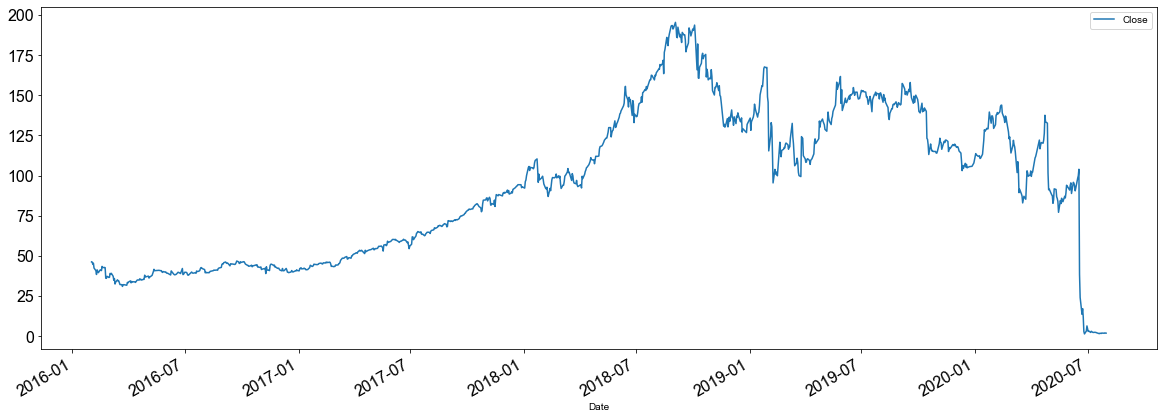

In [6]:
df_wdi.plot(x="Date", y="Close", figsize=(20,7), fontsize = 16)
matplt.style.use("seaborn")
matplt.show()

In [7]:
df_date = df[["tweet_id", "created_at", "sentiment_vader", "sentiment_bert"]]

In [8]:
for each in range(len(df_date)):
    df_date.loc[each, "created_at"] = df_date.loc[each, "created_at"].date()

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/3582451302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date.loc[each, "created_at"] = df_date.loc[each, "created_at"].date()


In [9]:
df_date.head()

tweet_id  created_at  sentiment_vader sentiment_bert
0  703142204341026818  2016-02-26           0.0992            NEU
1  695255175334924288  2016-02-04           0.4199            POS
2  695237701386244098  2016-02-04           0.0000            NEG
3  718385114170966016  2016-04-08           0.0000            NEU
4  718384477215567873  2016-04-08           0.0000            NEU

In [10]:
df_date.iloc[each]["sentiment_vader"]

0.639

In [11]:
list_date_count = df_date["tweet_id"].groupby(df_date["created_at"]).count()

In [12]:
list_date_count

created_at
2016-02-01     11
2016-02-02     31
2016-02-03     15
2016-02-04     28
2016-02-05     14
             ... 
2020-07-26    252
2020-07-27    385
2020-07-28    325
2020-07-29    429
2020-07-30    294
Name: tweet_id, Length: 1586, dtype: int64

In [13]:
len(list_date_count)

1586

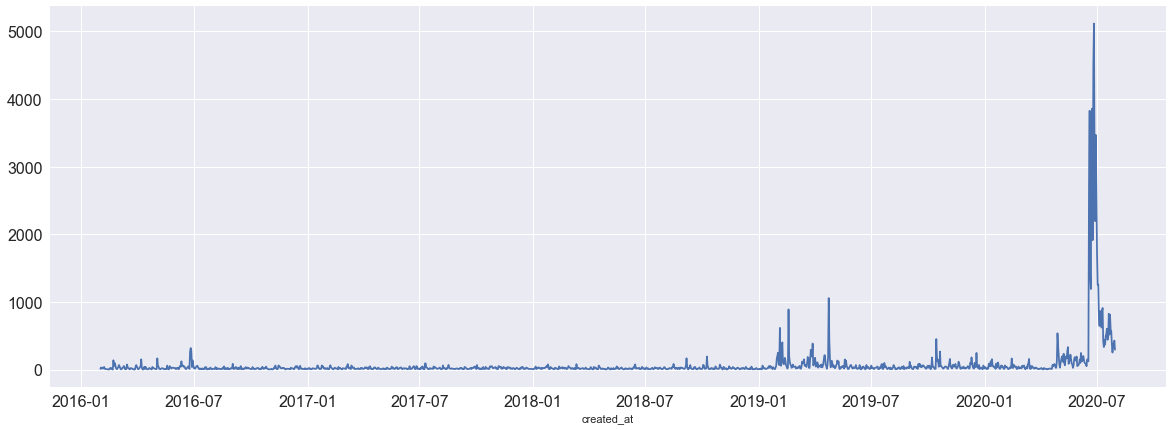

In [14]:
list_date_count.plot(x="created_at", figsize=(20,7), fontsize = 16)
matplt.style.use("seaborn")
matplt.show()

In [15]:
#Create a DF tgat
df_date_count = pd.DataFrame({"count_tweets": df_date["tweet_id"].groupby(df_date["created_at"]).count()}).reset_index()

In [16]:
#create a new df for sentiment values / BERT
df_sentiment = df[["created_at","tweet_id", "sentiment_bert"]]
for each in range(len(df_sentiment)):
    df_sentiment.loc[each, "created_at"] = df_sentiment.loc[each, "created_at"].date()
    
#Change the values from NEG, NEU, POS to -1, 0, 1
for each in range(len(df_sentiment)):
    if df_sentiment.loc[each, "sentiment_bert"] == "NEG":
        df_sentiment.loc[each, "sentiment_bert"] = -1
    elif df_sentiment.loc[each, "sentiment_bert"] == "NEU":
        df_sentiment.loc[each, "sentiment_bert"] = 0
    else:
        df_sentiment.loc[each, "sentiment_bert"] = 1

#Creates a DF for all negativ Values (BERT)
df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "tweet_id"]].reset_index(drop=True)

#Add the information about neg values from bert.
df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_neg"}),
                              how="outer", on="created_at").fillna(0)

#Creates a DF for all positiv Values (BERT)
df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "tweet_id"]].reset_index(drop=True)

#Add the information about pos values from bert.
df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_pos"}),
                              how="outer", on="created_at").fillna(0)

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/2445442024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment.loc[each, "created_at"] = df_sentiment.loc[each, "created_at"].date()


In [17]:
df_date_count.head(10)

created_at  count_tweets  count_bert_neg  count_bert_pos
0  2016-02-01            11             0.0             6.0
1  2016-02-02            31             0.0             6.0
2  2016-02-03            15             0.0             9.0
3  2016-02-04            28             1.0             7.0
4  2016-02-05            14             0.0             5.0
5  2016-02-06            28            21.0             0.0
6  2016-02-07            39            23.0             1.0
7  2016-02-08            11             7.0             0.0
8  2016-02-09            10             1.0             0.0
9  2016-02-10             7             1.0             2.0

<h2>VADER</h2>

In [18]:
#create a new df for sentiment values / BERT
df_sentiment_vader = df[["created_at","tweet_id", "sentiment_vader"]]
for each in range(len(df_sentiment_vader)):
    df_sentiment_vader.loc[each, "created_at"] = df_sentiment_vader.loc[each, "created_at"].date()
    
#Change the values from NEG, NEU, POS to -1, 0, 1
for each in range(len(df_sentiment_vader)):
    if df_sentiment_vader.loc[each, "sentiment_vader"] < -0.05:
        df_sentiment_vader.loc[each, "sentiment_vader"] = -1
    elif df_sentiment_vader.loc[each, "sentiment_vader"] > 0.05:
        df_sentiment_vader.loc[each, "sentiment_vader"] = 1
    else:
        df_sentiment_vader.loc[each, "sentiment_vader"] = 0

#Creates a DF for all negativ Values (BERT)
df_sentiment_vader_neg = df_sentiment_vader.loc[df_sentiment_vader["sentiment_vader"] == -1][["created_at", "tweet_id"]].reset_index(drop=True)

#Add the information about neg values from bert.
df_date_count = df_date_count.merge(df_sentiment_vader_neg.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_vader_neg"}),
                              how="outer", on="created_at").fillna(0)

#Creates a DF for all positiv Values (BERT)
df_sentiment_vader_pos = df_sentiment_vader.loc[df_sentiment_vader["sentiment_vader"] == 1][["created_at", "tweet_id"]].reset_index(drop=True)

#Add the information about pos values from bert.
df_date_count = df_date_count.merge(df_sentiment_vader_pos.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_vader_pos"}),
                              how="outer", on="created_at").fillna(0)

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/1849248485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment_vader.loc[each, "created_at"] = df_sentiment_vader.loc[each, "created_at"].date()


In [405]:
df_date_count.head(10)

created_at  count_tweets  count_bert_neg  count_bert_pos  count_vader_neg  \
0  2016-02-01            11             0.0             6.0              1.0   
1  2016-02-02            31             0.0             6.0              3.0   
2  2016-02-03            15             0.0             9.0              1.0   
3  2016-02-04            28             1.0             7.0              2.0   
4  2016-02-05            14             0.0             5.0              0.0   
5  2016-02-06            28            21.0             0.0             14.0   
6  2016-02-07            39            23.0             1.0             12.0   
7  2016-02-08            11             7.0             0.0              5.0   
8  2016-02-09            10             1.0             0.0              0.0   
9  2016-02-10             7             1.0             2.0              0.0   

   count_vader_pos  bert_neg_per      bert  
0              4.0      0.000000  1.000000  
1              8.0      0.000000  1.000000  
2              7.0      0.000000  1.000000  
3             11.0      0.035714  0.875000  
4              4.0      0.000000  1.000000  
5              2.0      0.750000  0.000000  
6             11.0      0.589744  0.041667  
7              1.0      0.636364  0.000000  
8              2.0      0.100000  0.000000  
9              3.0      0.142857  0.666667

In [415]:
df_date_count["bert"] = (df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])).fillna(0)

In [416]:
df_date_count.head()

created_at  count_tweets  count_bert_neg  count_bert_pos  count_vader_neg  \
0  2016-02-01            11             0.0             6.0              1.0   
1  2016-02-02            31             0.0             6.0              3.0   
2  2016-02-03            15             0.0             9.0              1.0   
3  2016-02-04            28             1.0             7.0              2.0   
4  2016-02-05            14             0.0             5.0              0.0   

   count_vader_pos  bert_neg_per   bert  
0              4.0      0.000000  0.000  
1              8.0      0.000000  0.000  
2              7.0      0.000000  0.000  
3             11.0      0.035714  0.125  
4              4.0      0.000000  0.000

In [417]:
df_date_count[df_date_count.bert.isna()]

Empty DataFrame
Columns: [created_at, count_tweets, count_bert_neg, count_bert_pos, count_vader_neg, count_vader_pos, bert_neg_per, bert]
Index: []

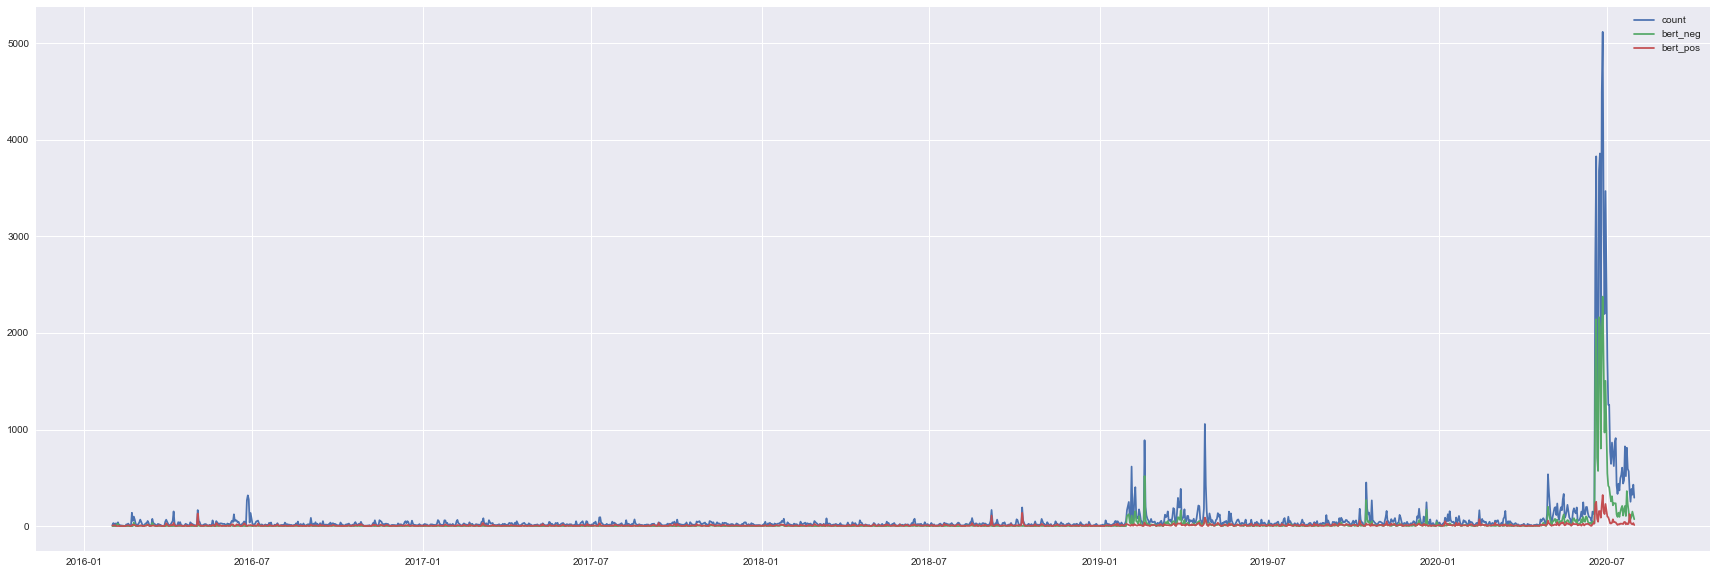

In [20]:
matplt.figure(figsize=(30,10))
matplt.plot(df_date_count["created_at"], df_date_count["count_tweets"], 
           df_date_count["created_at"], df_date_count["count_bert_neg"], 
           df_date_count["created_at"], df_date_count["count_bert_pos"])

matplt.legend(["count", "bert_neg", "bert_pos"])
matplt.style.use("seaborn")
matplt.show()

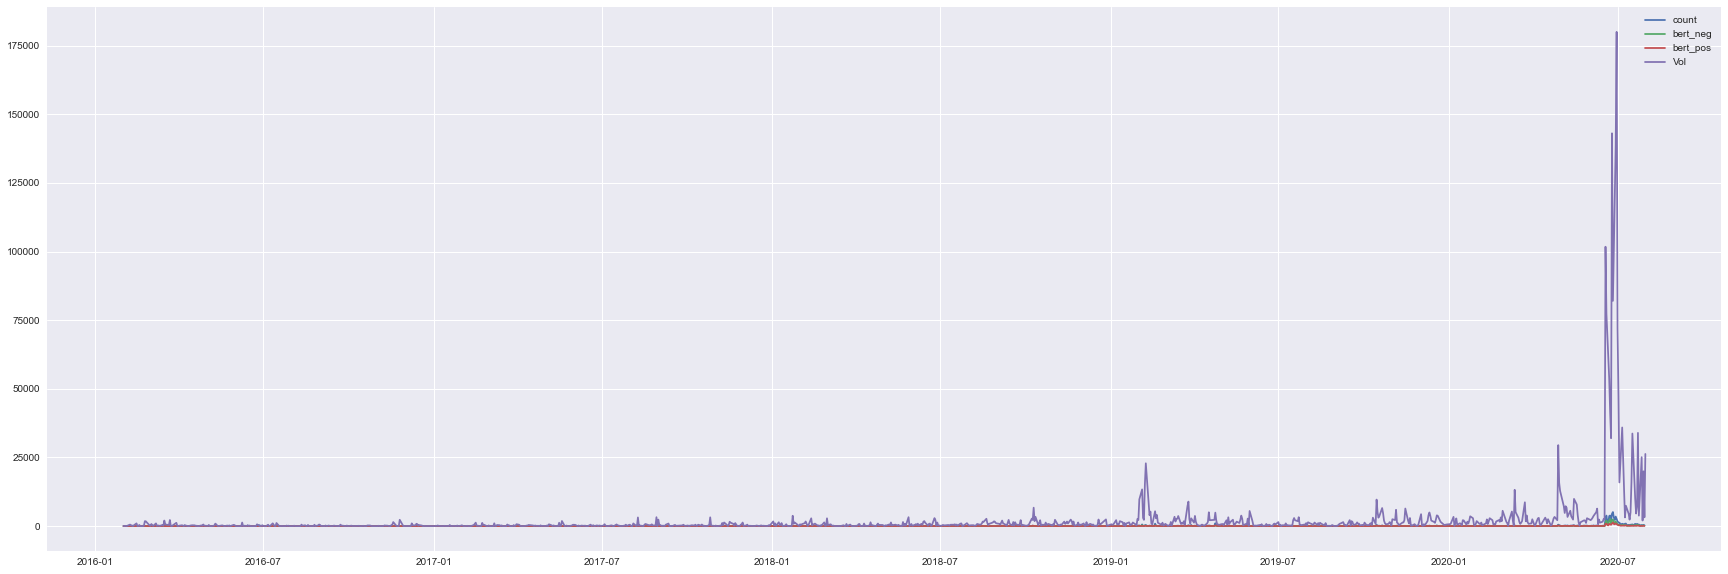

In [21]:
matplt.figure(figsize=(30,10))


matplt.plot(df_date_count["created_at"], df_date_count["count_tweets"], 
           df_date_count["created_at"], df_date_count["count_vader_neg"], 
           df_date_count["created_at"], df_date_count["count_vader_pos"],
           df_wdi["Date"], df_wdi["Volume"])
matplt.legend(["count", "bert_neg", "bert_pos", "Vol"])
matplt.style.use("seaborn")
matplt.show()

<h2>Ausprobieren</h2>

In [22]:
df_wdi.head()

Date       Open       High        Low      Close  Adj Close  Volume
0 2016-02-01  47.090000  47.090000  46.299999  46.299999  45.893112      69
1 2016-02-02  46.195000  46.195000  46.195000  46.195000  45.789028       0
2 2016-02-03  45.000000  45.000000  44.849998  44.849998  44.455849      90
3 2016-02-04  45.485001  45.485001  45.485001  45.485001  45.085274       0
4 2016-02-05  43.500000  44.000000  42.465000  42.465000  42.091812     110

In [24]:
df_wdi["Volatility"] = df_wdi["Open"] - df_wdi["Close"]

In [25]:
df_wdi.head(10)

Date       Open       High        Low      Close  Adj Close  Volume  \
0 2016-02-01  47.090000  47.090000  46.299999  46.299999  45.893112      69   
1 2016-02-02  46.195000  46.195000  46.195000  46.195000  45.789028       0   
2 2016-02-03  45.000000  45.000000  44.849998  44.849998  44.455849      90   
3 2016-02-04  45.485001  45.485001  45.485001  45.485001  45.085274       0   
4 2016-02-05  43.500000  44.000000  42.465000  42.465000  42.091812     110   
5 2016-02-08  43.180000  43.180000  40.840000  40.840000  40.481091     555   
6 2016-02-09  38.250000  38.439999  38.250000  38.439999  38.102184     211   
7 2016-02-10  39.685001  41.325001  39.685001  41.325001  40.961830     270   
8 2016-02-11  40.485001  40.485001  40.485001  40.485001  40.129211       0   
9 2016-02-12  39.630001  39.630001  39.549999  39.549999  39.202427     250   

   Volatility  
0    0.790001  
1    0.000000  
2    0.150002  
3    0.000000  
4    1.035000  
5    2.340000  
6   -0.189999  
7   -1.640000  
8    0.000000  
9    0.080002

In [31]:
(df_date_count["count_bert_pos"] / df_date_count["count_tweets"]).max()

1.0

In [43]:
(df_wdi["Open"] - df_wdi["Close"]).max()

66.55999700000001

In [44]:
df_date_count["count_tweets"].max()

5117

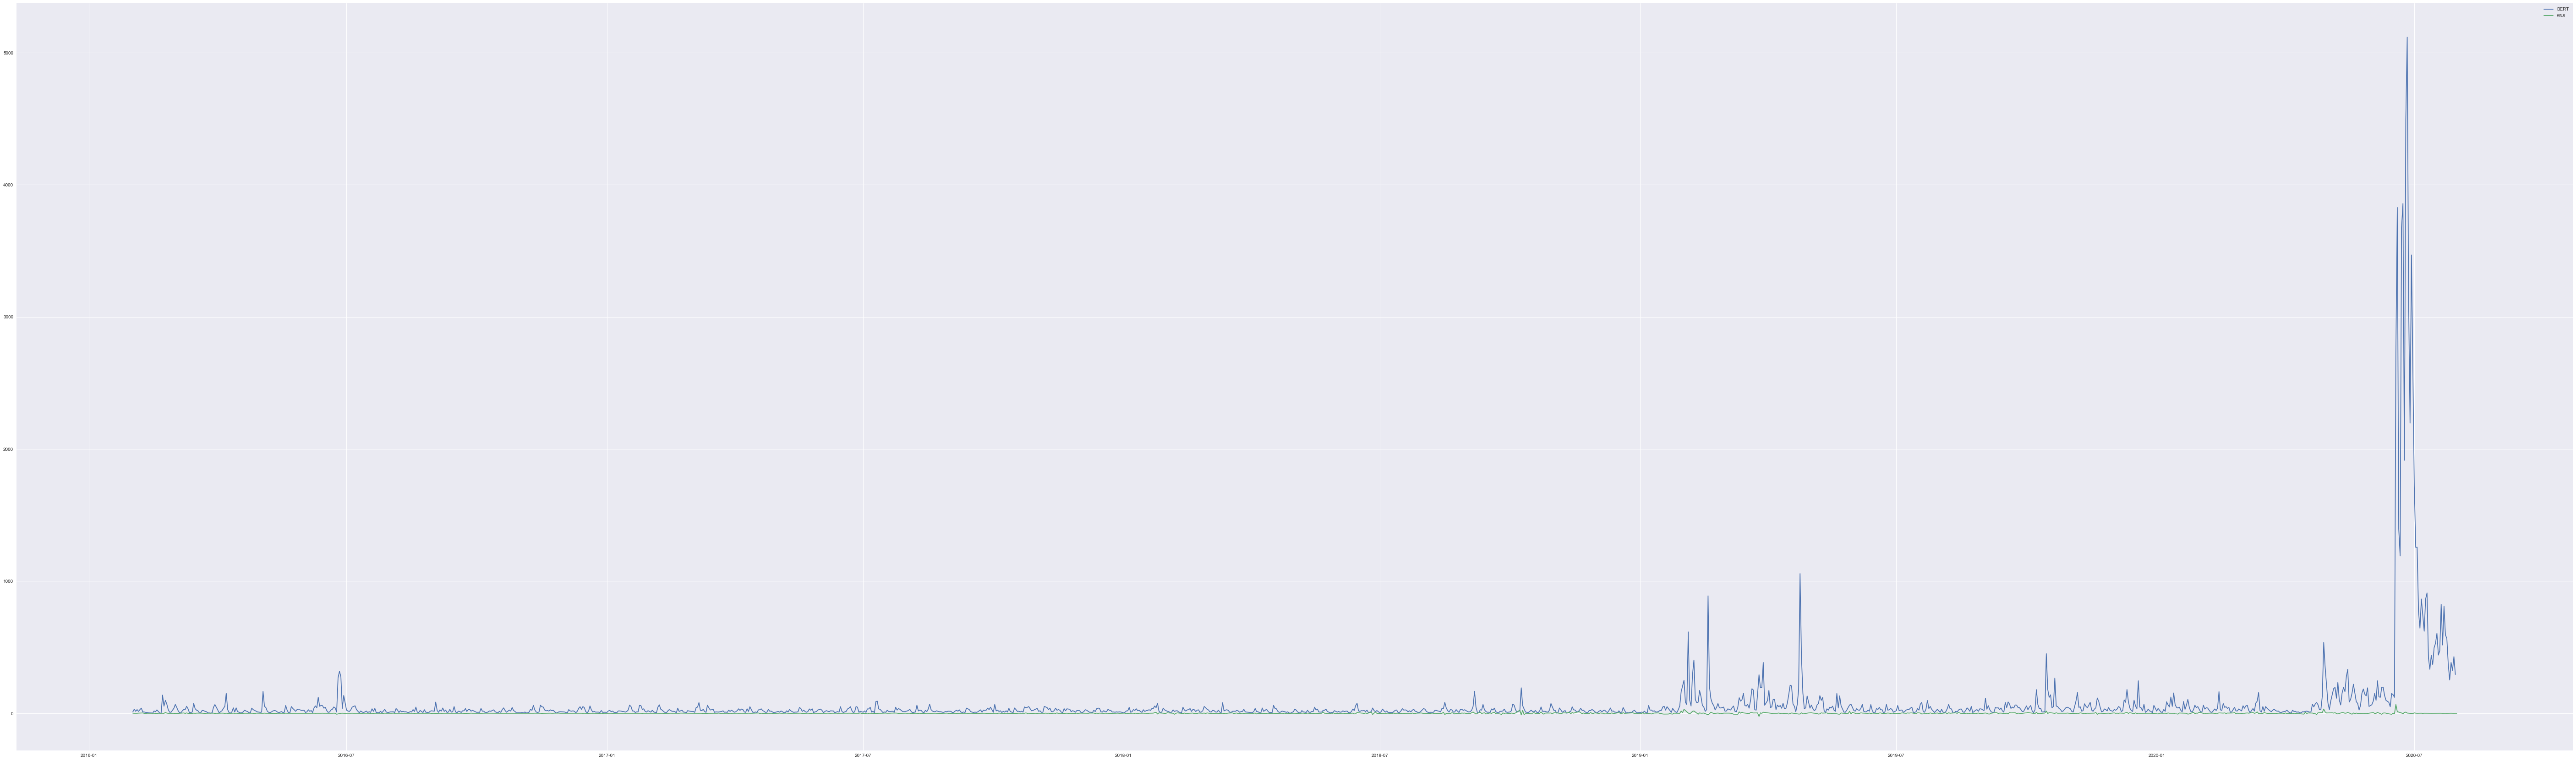

In [45]:
matplt.figure(figsize=(100,30))


matplt.plot(df_date_count["created_at"], df_date_count["count_tweets"],
           df_wdi["Date"], df_wdi["Volatility"])
matplt.legend(["BERT", "WDI"])
matplt.style.use("seaborn")
matplt.show()

<Figure size 7200x2880 with 0 Axes>

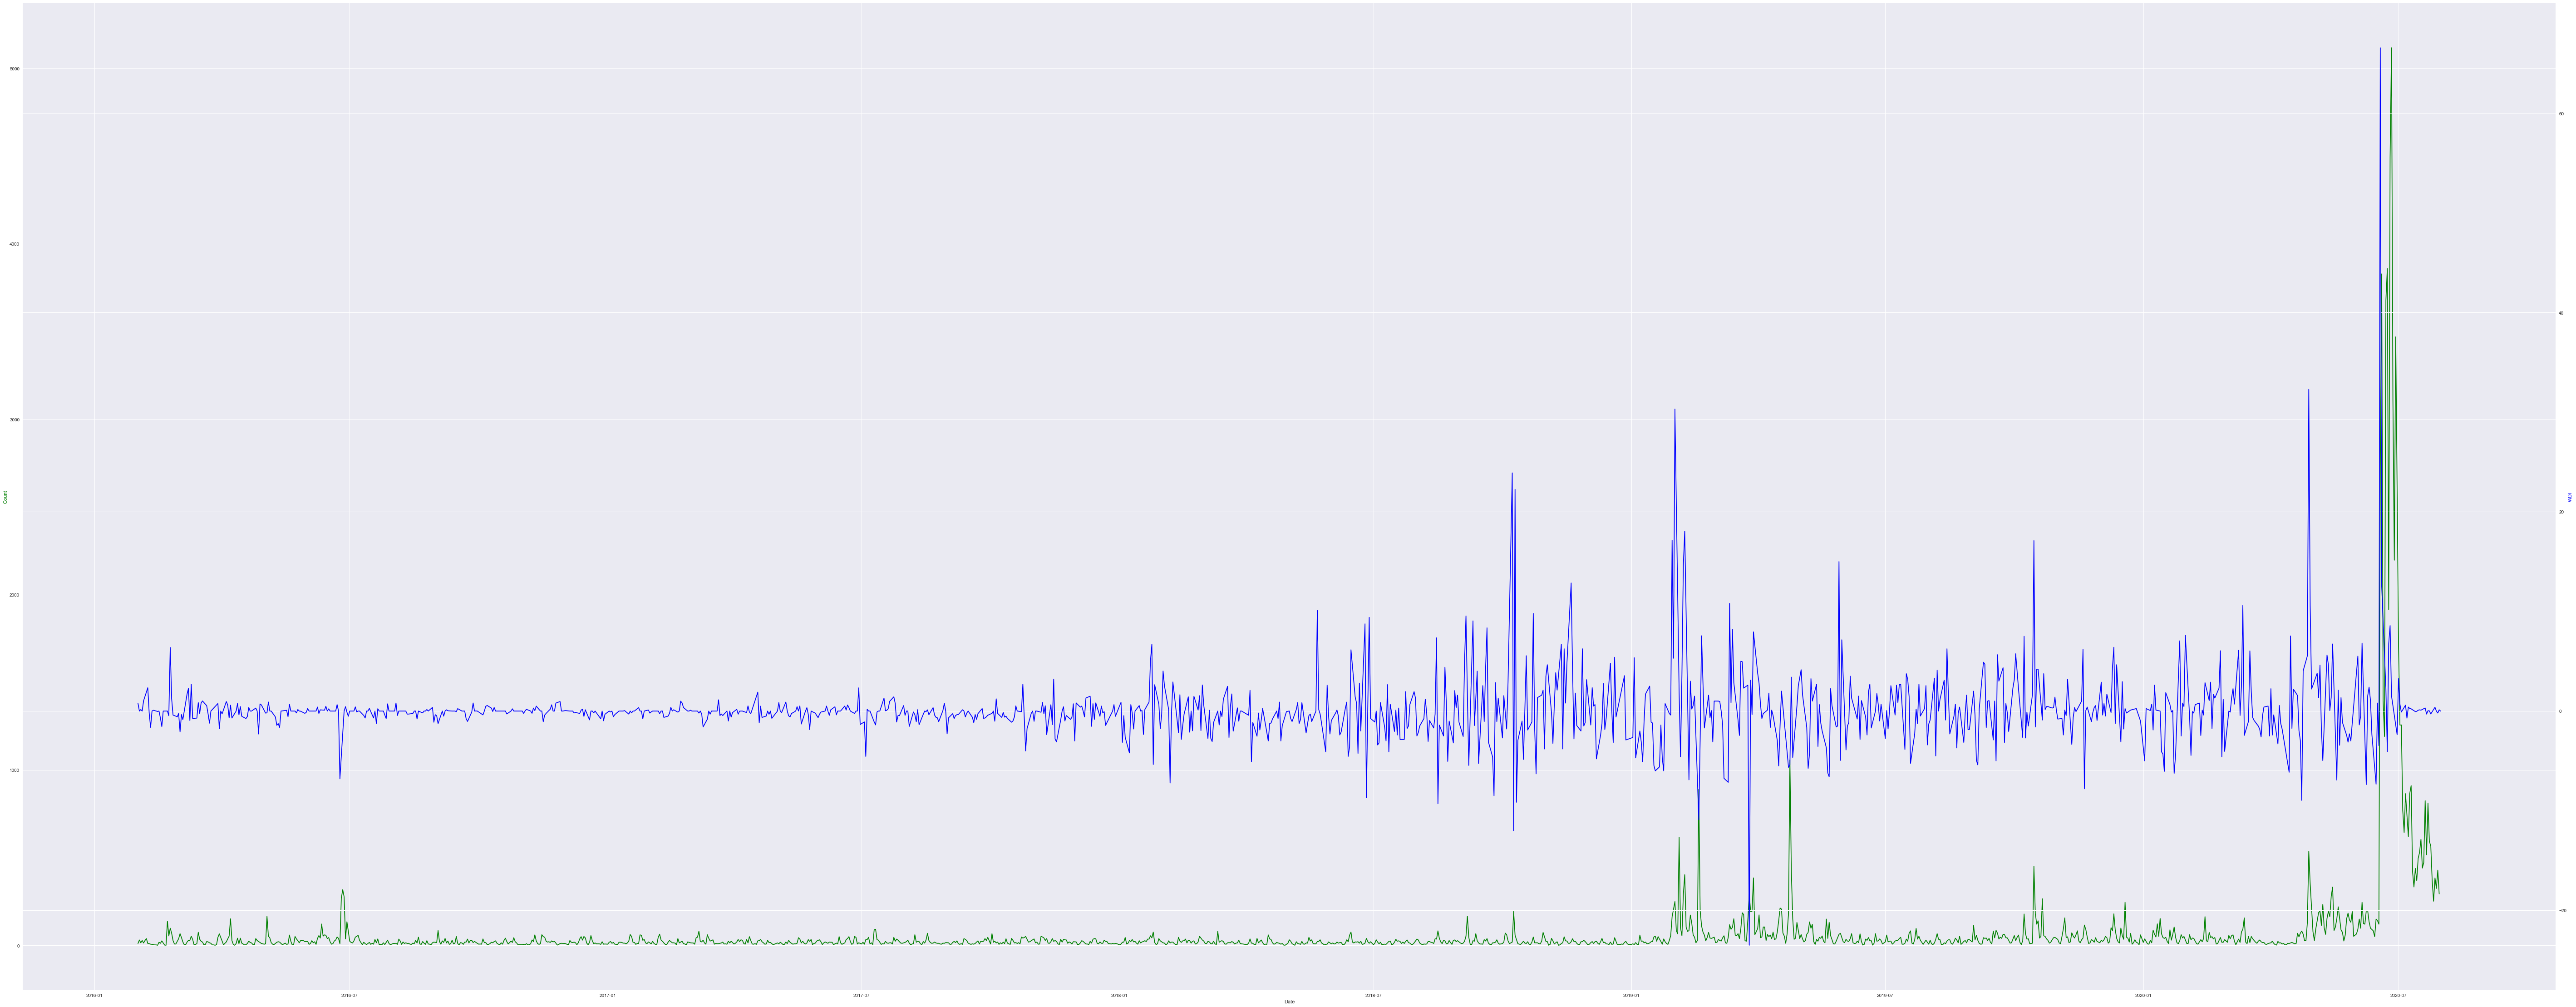

In [68]:
matplt.figure(figsize=(100,40))

fig, ax1 = matplt.subplots(figsize=(100,40))
ax2 = ax1.twinx()
ax1.plot(df_date_count["created_at"], df_date_count["count_tweets"], "g-")
ax2.plot(df_wdi["Date"], df_wdi["Volatility"], "b-")

ax1.set_xlabel("Date")
ax1.set_ylabel("Count", color="g")
ax2.set_ylabel("WDI", color="b")
matplt.style.use("seaborn")


matplt.show()

<h2>Regression Test</h2>

In [70]:
model = LinearRegression()

In [125]:
df_wdi["Date2"] = df_wdi["Date"]

for each in range(len(df_wdi)):
    df_wdi.loc[each, "Date2"] = df_wdi.loc[each, "Date2"].date()

In [238]:
len(df_date_count)

1586

In [237]:
len(df_wdi)

1141

In [351]:
df_test_1 = df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])][["created_at", "count_tweets"]].reset_index(drop=True)
df_test_2 = pd.DataFrame(df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])]["Date"].dt.date)
df_test_2 = df_test_2.rename(columns={"Date": "created_at"})
df_test_2["count_tweets"] = 0
df_test = df_test_1.append(df_test_2).reset_index(drop=True).sort_values(by="created_at").reset_index(drop=True)


x = np.array(df_test["count_tweets"]).reshape((-1, 1))
y = np.array(df_wdi["Volume"])

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/1609405031.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test_1.append(df_test_2).reset_index(drop=True).sort_values(by="created_at").reset_index(drop=True)


In [418]:
df_test_1 = df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])][["created_at", "bert"]].reset_index(drop=True)
df_test_2 = pd.DataFrame(df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])]["Date"].dt.date)
df_test_2 = df_test_2.rename(columns={"Date": "created_at"})
df_test_2["bert"] = 0
df_test = df_test_1.append(df_test_2).reset_index(drop=True).sort_values(by="created_at").reset_index(drop=True)


x = np.array(df_test["bert"]).reshape((-1, 1))
y = np.array(df_wdi["Adj Close"])

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/2325689186.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test = df_test_1.append(df_test_2).reset_index(drop=True).sort_values(by="created_at").reset_index(drop=True)


In [419]:
x

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.78014184],
       [0.86585366],
       [0.        ]])

In [420]:
y

array([45.893112, 45.789028, 44.455849, ...,  2.05    ,  1.928   ,
        1.89    ])

In [421]:
model.fit(x,y)

LinearRegression()

In [422]:
model = LinearRegression().fit(x,y)

In [423]:
r_sq = model.score(x,y)
print(f"Coefficient of determination: {r_sq}")

Coefficient of determination: 0.00043993381645890395


In [87]:
x[1585]

array([294])

In [89]:
y[1140]

-0.0009999999999998899

In [242]:
series_test = df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"]

In [245]:
for each in df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])].index:
    series_test[each] = 0

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/3345890015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_test[each] = 0
/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/3345890015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_test[each] = 0
/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/3345890015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_test[each]

In [247]:
series_test[22]

datetime.date(2016, 2, 23)

In [270]:
df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])]

Date        Open        High         Low       Close   Adj Close  \
20   2016-02-29   36.000000   36.570000   34.845001   36.570000   36.248615   
41   2016-03-31   33.200001   33.200001   33.200001   33.200001   32.908237   
83   2016-05-31   39.919998   40.044998   39.900002   40.044998   39.693077   
105  2016-06-30   38.799999   39.555000   38.799999   39.320000   39.116951   
149  2016-08-31   44.709999   45.455002   44.709999   45.075001   44.842236   
171  2016-09-30   45.930000   45.930000   45.930000   45.930000   45.692814   
191  2016-10-31   42.785000   42.785000   42.785000   42.785000   42.564056   
213  2016-11-30   42.345001   42.345001   42.345001   42.345001   42.126331   
256  2017-01-31   44.294998   44.500000   44.294998   44.500000   44.270206   
276  2017-02-28   43.435001   43.435001   43.435001   43.435001   43.210705   
299  2017-03-31   50.900002   51.230000   50.900002   51.049999   50.786381   
339  2017-05-31   58.689999   59.349998   58.689999   59.349998   59.043514   
361  2017-06-30   54.720001   56.139999   54.720001   56.070000   55.928661   
382  2017-07-31   65.300003   65.300003   64.750000   64.750000   64.586784   
405  2017-08-31   69.599998   71.889999   69.599998   71.889999   71.708786   
448  2017-10-31   84.879997   84.879997   84.879997   84.879997   84.666031   
470  2017-11-30   86.610001   89.610001   86.610001   89.610001   89.384117   
511  2018-01-31   99.300003  101.849998   99.000000   99.620003   99.368881   
531  2018-02-28   97.639999   99.599998   97.639999   99.599998   99.348930   
572  2018-04-30  111.949997  113.199997  111.949997  112.000000  111.717674   
594  2018-05-31  130.050003  133.000000  130.050003  132.350006  132.016388   
637  2018-07-31  160.899994  161.300003  159.149994  159.600006  159.393875   
660  2018-08-31  190.899994  192.000000  190.050003  192.000000  191.752014   
702  2018-10-31  162.199997  166.000000  162.149994  166.000000  165.785599   
724  2018-11-30  137.000000  137.000000  132.850006  133.850006  133.677124   
763  2019-01-31  151.000000  153.350006  143.000000  145.699997  145.511810   
783  2019-02-28  116.500000  119.599998  116.400002  119.599998  119.445526   
824  2019-04-30  136.250000  136.250000  133.699997  133.699997  133.527313   
846  2019-05-31  147.699997  147.699997  132.000000  140.550003  140.368469   
888  2019-07-31  147.899994  151.300003  147.899994  151.300003  151.300003   
931  2019-09-30  149.750000  149.750000  147.199997  147.449997  147.449997   
953  2019-10-31  114.099998  115.000000  113.800003  114.000000  114.000000   
1014 2020-01-31  137.000000  137.000000  128.199997  129.399994  129.399994   
1056 2020-03-31  100.400002  105.699997  100.400002  102.900002  102.900002   
1076 2020-04-30   93.800003   96.599998   89.389999   91.589996   91.589996   
1117 2020-06-30    4.030000    9.300000    4.000000    6.400000    6.400000   
1140 2020-07-31    1.889000    1.950000    1.889000    1.890000    1.890000   

      Volume  Volatility       Date2  
20       305   -0.570000  2016-02-29  
41         0    0.000000  2016-03-31  
83       292   -0.125000  2016-05-31  
105      300   -0.520001  2016-06-30  
149      437   -0.365002  2016-08-31  
171        0    0.000000  2016-09-30  
191        0    0.000000  2016-10-31  
213        0    0.000000  2016-11-30  
256      300   -0.205002  2017-01-31  
276        0    0.000000  2017-02-28  
299      680   -0.149997  2017-03-31  
339      517   -0.659999  2017-05-31  
361       20   -1.349999  2017-06-30  
382      520    0.550003  2017-07-31  
405     2370   -2.290001  2017-08-31  
448        0    0.000000  2017-10-31  
470     1300   -3.000000  2017-11-30  
511      667   -0.320000  2018-01-31  
531      147   -1.959999  2018-02-28  
572      405   -0.050003  2018-04-30  
594      776   -2.300003  2018-05-31  
637      618    1.299988  2018-07-31  
660      999   -1.100006  2018-08-31  
702      719   -3.800003  2018-10-31  
724      433    3.149994  2018-11

In [211]:
df.loc[df["created_at"].dt.date == datetime.date(2016, 2, 29)]

Empty DataFrame
Columns: [conversation_id, author_id, created_at, tweet_id, lang, retweet_count, reply_count, like_count, quote_count, source, tweet_type, referenced_tweet_id, text, sentiment_bert, sentiment_vader]
Index: []

In [260]:
series_test = df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["count_tweets"]

In [267]:
series_test[1140]

153

In [249]:
for each in df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])].index:
    series_test[each] = 0

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/418503829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_test[each] = 0
/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/418503829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_test[each] = 0
/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/418503829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_test[each] = 

In [256]:
series_test.tail()

594    0
702    0
763    0
783    0
824    0
Name: count_tweets, dtype: int64

<h2>Test</h2>

In [375]:
df_sentiment_vader = df[["created_at","tweet_id", "sentiment_vader"]]
for each in range(len(df_sentiment_vader)):
    df_sentiment_vader.loc[each, "created_at"] = df_sentiment_vader.loc[each, "created_at"].date()

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_5777/1884604748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment_vader.loc[each, "created_at"] = df_sentiment_vader.loc[each, "created_at"].date()


In [376]:
df_sentiment_vader.head()

created_at            tweet_id  sentiment_vader
0  2016-02-26  703142204341026818           0.0992
1  2016-02-04  695255175334924288           0.4199
2  2016-02-04  695237701386244098           0.0000
3  2016-04-08  718385114170966016           0.0000
4  2016-04-08  718384477215567873           0.0000

In [377]:
for each in range(len(df_sentiment_vader)):
    if df_sentiment_vader.loc[each, "sentiment_vader"] < -0.05:
        df_sentiment_vader.loc[each, "sentiment_vader"] = -1
    elif df_sentiment_vader.loc[each, "sentiment_vader"] > 0.05:
        df_sentiment_vader.loc[each, "sentiment_vader"] = 1
    else:
        df_sentiment_vader.loc[each, "sentiment_vader"] = 0

In [378]:
df_sentiment_vader.head()

created_at            tweet_id  sentiment_vader
0  2016-02-26  703142204341026818              1.0
1  2016-02-04  695255175334924288              1.0
2  2016-02-04  695237701386244098              0.0
3  2016-04-08  718385114170966016              0.0
4  2016-04-08  718384477215567873              0.0

In [398]:
print(datetime.date(2020, 12, 31) + datetime.timedelta(days = 1))

2021-01-01


In [313]:
df_test_1 = df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])][["created_at", "count_tweets"]].reset_index(drop=True)

In [314]:
df_test_1.head(25)

created_at  count_tweets
0   2016-02-01            11
1   2016-02-02            31
2   2016-02-03            15
3   2016-02-04            28
4   2016-02-05            14
5   2016-02-08            11
6   2016-02-09            10
7   2016-02-10             7
8   2016-02-11             6
9   2016-02-12             4
10  2016-02-15             1
11  2016-02-16            18
12  2016-02-17            12
13  2016-02-18            26
14  2016-02-19            14
15  2016-02-22           138
16  2016-02-23            54
17  2016-02-24            98
18  2016-02-25            70
19  2016-02-26            28
20  2016-03-01            38
21  2016-03-02            67
22  2016-03-03            45
23  2016-03-04            20
24  2016-03-07            19

In [325]:
df_test_2 = pd.DataFrame(df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])]["Date"].dt.date)

In [331]:
df_test_1 = df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])][["created_at", "count_tweets"]].reset_index(drop=True)
df_test_2 = pd.DataFrame(df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])]["Date"].dt.date)
df_test_2 = df_test_2.rename(columns={"Date": "created_at"})
df_test_2["count_tweets"] = 0
df_test_1.append(df_test_2).reset_index(drop=True).sort_values(by="created_at").reset_index(drop=True)

In [332]:
df_test_2

created_at  count_tweets
20    2016-02-29             0
41    2016-03-31             0
83    2016-05-31             0
105   2016-06-30             0
149   2016-08-31             0
171   2016-09-30             0
191   2016-10-31             0
213   2016-11-30             0
256   2017-01-31             0
276   2017-02-28             0
299   2017-03-31             0
339   2017-05-31             0
361   2017-06-30             0
382   2017-07-31             0
405   2017-08-31             0
448   2017-10-31             0
470   2017-11-30             0
511   2018-01-31             0
531   2018-02-28             0
572   2018-04-30             0
594   2018-05-31             0
637   2018-07-31             0
660   2018-08-31             0
702   2018-10-31             0
724   2018-11-30             0
763   2019-01-31             0
783   2019-02-28             0
824   2019-04-30             0
846   2019-05-31             0
888   2019-07-31             0
931   2019-09-30             0
953   2019-10-31             0
1014  2020-01-31             0
1056  2020-03-31             0
1076  2020-04-30             0
1117  2020-06-30             0
1140  2020-07-31             0

In [344]:
df_test_1.append(df_test_2).reset_index(drop=True).sort_values(by="created_at").reset_index(drop=True)

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/3376693378.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_1.append(df_test_2).reset_index(drop=True).sort_values(by="created_at").reset_index(drop=True)


created_at  count_tweets
0     2016-02-01            11
1     2016-02-02            31
2     2016-02-03            15
3     2016-02-04            28
4     2016-02-05            14
...          ...           ...
1136  2020-07-27           385
1137  2020-07-28           325
1138  2020-07-29           429
1139  2020-07-30           294
1140  2020-07-31             0

[1141 rows x 2 columns]

In [323]:
s1.append(s2).reset_index(drop=True)

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_978/2131633131.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s1.append(s2).reset_index(drop=True)


0       2016-02-01
1       2016-02-02
2       2016-02-03
3       2016-02-04
4       2016-02-05
           ...    
1136    2020-01-31
1137    2020-03-31
1138    2020-04-30
1139    2020-06-30
1140    2020-07-31
Length: 1141, dtype: object

In [302]:
len(s1)

1104

In [303]:
s1 = df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["count_tweets"]

In [ ]:
s2 = df_wdi[~df_wdi.Date.isin(df_date_count[df_date_count.created_at.isin(df_wdi["Date2"])]["created_at"])]["Date"].dt.date